This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

# Real 𝑓_NL

This ipynb provides the code necessary to compute the real factor of Non-Linear effects $\mathit{f}_{\rm NL}$, and to compare it to the effective one.

All the output files will be placed in the following directory:

In [35]:
#DIR = "/Users/matteofoglieni/Dropbox/GR_effects/Matteo_Output/fNL_effective_z115/";
DIR = "Real_fNL_z115_files/";
DIR_xis = "Effective_fNL_z115_files/";

ps_kwargs(twofast::Bool) = twofast ?
    Dict(:twofast=>true, :epl => true, :pr => false, 
          :N_left => 12, :N_right => 12,
          :p0_left => [-2.0, 1.0], :p0_right => [-2.0, 1.0],
          :int_s_min => 1e0, :int_s_max => 1200.0) :
    Dict(:twofast=>false, :pr=>true, :ν => 1.5, :n_extrap_low => 0,
     :n_extrap_high => 0, :n_pad => 500, :cut_first_n=>6);
tf = false;

## Basic Framework

In [2]:
PATH_TO_GAPSE = "../";

In [3]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [4]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, TwoFAST, ProgressMeter
using Printf, LaTeXStrings, Turing, StatsPlots, GridInterpolations, LegendrePolynomials
pyplot()

Plots.PyPlotBackend()

In [5]:
#z_min, z_max, θ_max = 0.05, 0.20, π / 2.0
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0

WFI_opts = Dict(
    :ss_start => 0.0, :ss_stop => 0.0, 
    :ss_step => 50, :llim => 0.0, :rlim => Inf, 
    :rtol => 5e-2, :atol => 0.0, :N => 1000, #:pr => true,
)

FILE_F_MAP = PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt"
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt"
FILE_BACKGROUND = PATH_TO_GAPSE * "test/datatest/WideA_ZA_background.dat"

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.0,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    WFI_opts = WFI_opts,
);

In [6]:
#=
new_calc_μs = union([μ for μ in -1.0:0.01:(-0.9)], 
        [μ for μ in -0.9:0.05:0.9], 
        [μ for μ in 0.9:0.01:1.0]);
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"

GaPSE.print_map_IntegratedF(
    FILE_F_MAP, FILE_IF_MAP, 
    z_min, z_max, new_calc_μs, FILE_BACKGROUND;
    trap = true, WFI_opts...
)
=#

In [7]:
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../test/datatest/WideA_ZA_background.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Integrated F window function input file: "../data/IntF_pi2_z115.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.0 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - CosmoParams about the Integrated Window Function F: 
#	 ss_step = 50 	 N = 1000 	 rtol = 0.05

## Creation of a CosmoPNG struct

In [8]:
cosmopng = GaPSE.CosmoPNG(cosmo, "../data/Tk.dat");

In [9]:
#ks_tf, pks_tf = GaPSE.readxy("../data/Tk.dat");
#T = Spline1D(ks_tf, pks_tf; bc ="error");
ks_all_tf, pks_all_tf = GaPSE.readxall("../data/WideA_ZA_tk.dat", comments=true);
orig_T = Spline1D(ks_all_tf, pks_all_tf[end]; bc ="error");

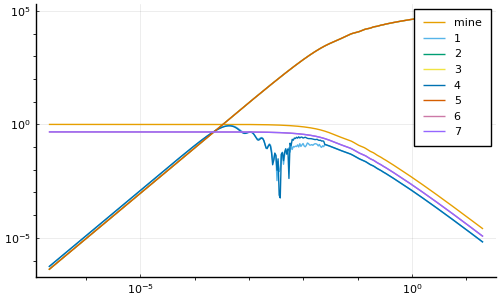

In [10]:
P = plot(ks_all_tf, cosmopng.tf.(ks_all_tf), axis=:log, label="mine", size=(500, 300))
for (i, ys) in enumerate(pks_all_tf)
    plot!(P, ks_all_tf, abs.(ys), label="$i")
end
P

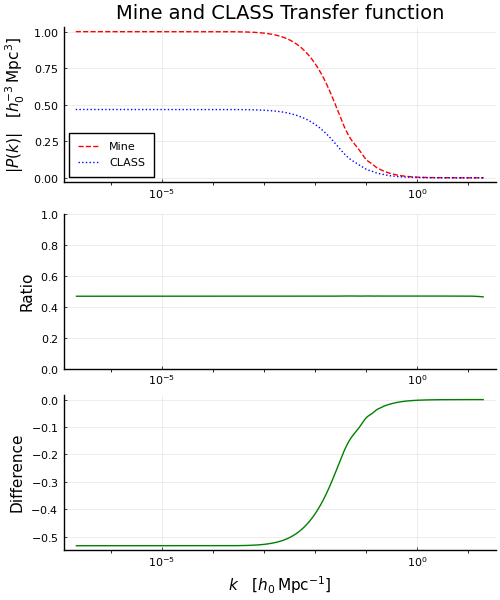

In [11]:
xs_1 = ks_all_tf
ys_1 = cosmopng.tf.(ks_all_tf)

xs_2 = ks_all_tf
ys_2 =  abs.(pks_all_tf[7]) 
spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "Mine and CLASS Transfer function",
    label=["Mine" "CLASS"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0,1), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
p3 = plot(xs_1, spline.(xs_1) .- ys_1, 
    ylabel="Difference", lc=:green, 
    xaxis=:log,
    #ylim=(0.0,1), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#display(P)

## Reading Casto I00 and I20

In [12]:
casto_ss, casto_Js = GaPSE.readxall("../data/I_alpha.dat");
casto_J0s, casto_J2s = casto_Js[1], casto_Js[2];

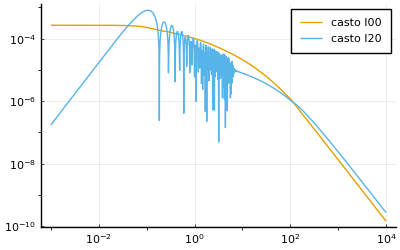

In [13]:
plot(casto_ss, casto_J0s, axis=:log, size=(400, 250), label = "casto I00")
plot!(casto_ss, abs.(casto_J2s), label = "casto I20")

## S monopole and dipole

In [14]:
ss = 10 .^ range(-3,4; length=300);
J0s = [cosmopng.J0(s) for s in ss]
J2s = [cosmopng.J2(s) for s in ss]
I02s = [cosmo.tools.I02(s) * s^2 for s in ss]; 
I22s = [cosmo.tools.I22(s) * s^2 for s in ss]; 

In [15]:
3/2*cosmo.params.Ω_M0/0.779017/cosmo.D_of_s(0), 0.779017^2

(0.5774970250970135, 0.6068674862889999)

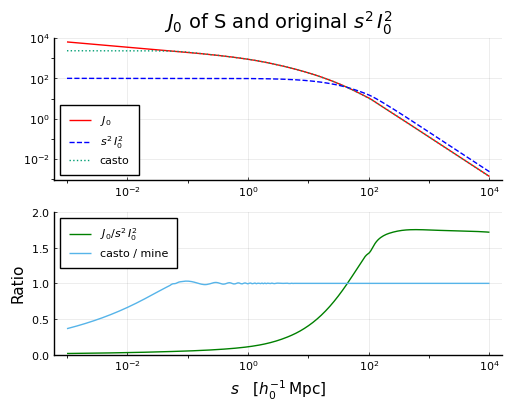

In [16]:
xs_1 = ss
ys_1 = J0s ./ (100 / 299792.458) .^2

xs_2 = ss
ys_2 = I02s
spline_2 = Spline1D(xs_2, ys_2)

xs_3 = casto_ss
ys_3 = casto_J0s ./ (100 / 299792.458) .^2
spline_3 = Spline1D(xs_3, ys_3)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"J_0"*" of S and original " * L"s^2 \, I_0^2",
    label=[L"J_0" L"s^2 \, I_0^2"], ls=[:solid :dash], 
    legend=:bottomleft)
plot!(p1, xs_3, ys_3, label="casto", ls=:dot)

p2 = plot(xs_1, spline_2.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, label = L"J_0 / s^2 \, I_0^2",
    ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
plot!(p2, xs_1, spline_3.(xs_1) ./ ys_1, label = "casto / mine")
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )
savefig(P, DIR*"J0_of_S.pdf")

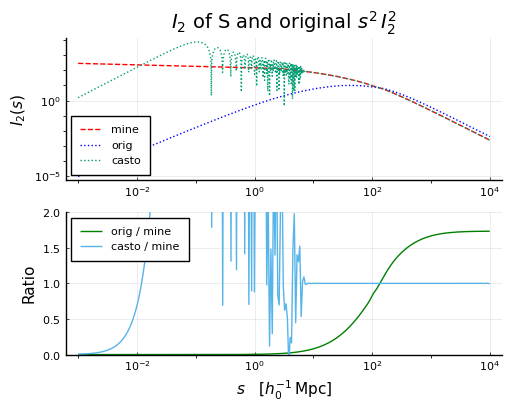

In [17]:
xs_1 = ss
ys_1 = J2s ./ (100 / 299792.458) .^2  #.* 1e13

xs_2 = ss
ys_2 = I22s
spline_2 = Spline1D(xs_2, ys_2)

xs_3 = casto_ss
ys_3 = abs.(casto_J2s) ./ (100 / 299792.458) .^2
spline_3 = Spline1D(xs_3, ys_3)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"I_2"*" of S and original " * L"s^2 \, I_2^2",
    label=["mine" "orig"], ls=[:dash :dot], 
    ylabel = L"I_2(s)",
    legend=:bottomleft)
plot!(p1, xs_3, ys_3, label="casto", ls=:dot)

p2 = plot(xs_1, spline_2.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, label = "orig / mine",
    ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
plot!(p2, xs_1, spline_3.(xs_1) ./ ys_1, label = "casto / mine")
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )
savefig(P, DIR*"J2_of_S.pdf")

## Code TPCF and PS of S

In [18]:
GaPSE.print_map_ξ_S_multipole(cosmo, cosmopng, DIR * "map_xi_S_L0_withF.dat",
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=0, use_windows = true);
GaPSE.print_PS_multipole(DIR * "map_xi_S_L0_withF.dat", 
    DIR * "map_ps_S_L0_withF.dat"; L = 0, ps_kwargs(tf)...);

ss_S_L0_withF, xis_S_L0_withF = GaPSE.readxy(DIR * "map_xi_S_L0_withF.dat");
ks_S_L0_withF, pks_S_L0_withF = GaPSE.readxy(DIR * "map_ps_S_L0_withF.dat");

ξ_S, L=0: 100%|█████████████████████████████████████████| Time: 0:00:04



time needed for map_ξ_S_multipole [in s] = 4.07421 

I'm computing the PS_multipole from the file "Effective_fNL_z115_files/map_xi_S_L0_withF.dat" 

time needed for this Power Spectrum computation [in s] = 0.21018385887145996



([0.00016369382206909115, 0.00016657867325727587, 0.00016951436549903702, 0.00017250179478954422, 0.0001755418729144996, 0.00017863552772842304, 0.00018178370343783885, 0.00018498736088945543, 0.0001882474778634232, 0.00019156504937175922  …  0.7694729466462702, 0.7830337207570459, 0.7968334825999892, 0.8108764439653464, 0.8251668908696714, 0.8397091848639511, 0.8545077643647822, 0.86956714600901, 0.8848919260322392, 0.9004867816716393], [145.2349796858248, 145.18236446888974, 145.12792400142217, 145.07159833528564, 145.01332053455866, 144.9530282629347, 144.8906523181804, 144.82612215369272, 144.7593681128691, 144.69031372044176  …  0.0009604395062982871, 0.0008971141720922243, 0.000836882337619846, 0.0007794048699595332, 0.000724319140844438, 0.0006721187473777054, 0.0006222049510727422, 0.0005745306838777222, 0.000529386850507797, 0.0004861196653458122])

In [34]:
GaPSE.print_map_ξ_S_multipole(cosmo, cosmopng, DIR * "map_xi_S_L2_withF.dat",
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=2, use_windows = true);
GaPSE.print_PS_multipole(DIR * "map_xi_S_L2_withF.dat", 
    DIR * "map_ps_S_L2_withF.dat"; L = 2, ps_kwargs(tf)...);

ss_S_L2_withF, xis_S_L2_withF = GaPSE.readxy(DIR * "map_xi_S_L2_withF.dat");
ks_S_L2_withF, pks_S_L2_withF = GaPSE.readxy(DIR * "map_ps_S_L2_withF.dat");

ξ_S, L=2: 100%|█████████████████████████████████████████| Time: 0:00:08



time needed for map_ξ_S_multipole [in s] = 8.75756 

I'm computing the PS_multipole from the file "Effective_fNL_z115_files/map_xi_S_L2_withF.dat" 

time needed for this Power Spectrum computation [in s] = 0.0016050338745117188



## Check Plot S multipoles

In [ ]:
xs_1 = ss_S_L0_withF
ys_1 = xis_S_L0_withF

xs_2 = ss_S_L2_withF
ys_2 = xis_S_L2_withF
spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"I_2"*" of S and original " * L"s^2 \, I_2^2",
    label=["mine" "orig"], ls=[:dash :dot], 
    ylabel = L"I_2(s)",
    legend=:bottomleft)
plot!(p1, xs_3, ys_3, label="casto", ls=:dot)

p2 = plot(xs_1, spline_2.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, label = "orig / mine",
    ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
plot!(p2, xs_1, spline_3.(xs_1) ./ ys_1, label = "casto / mine")
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )
savefig(P, DIR*"J2_of_S.pdf")

## Code for reading TPCF and PS of Newtonian, ALLGRsum and PPMatter

In [36]:
ss_LD_L0_withF, xis_sum_LD_L0_withF, all_xis_LD_L0_withF = 
    GaPSE.readxyall(DIR_xis*"map_sum_xis_LD_L0_withF.txt");
ss_GNC_L0_withF, xis_sum_GNC_L0_withF, all_xis_GNC_L0_withF = 
    GaPSE.readxyall(DIR_xis*"map_sum_xis_GNC_L0_withF.txt");
ss_GNCxLD_L0_withF, xis_sum_GNCxLD_L0_withF, all_xis_GNCxLD_L0_withF = 
    GaPSE.readxyall(DIR_xis*"map_sum_xis_GNCxLD_L0_withF.txt");
ss_LDxGNC_L0_withF, xis_sum_LDxGNC_L0_withF, all_xis_LDxGNC_L0_withF = 
    GaPSE.readxyall(DIR_xis*"map_sum_xis_LDxGNC_L0_withF.txt");

spline_LD_sum_L0_withF = Spline1D(ss_LD_L0_withF, xis_sum_LD_L0_withF; bc = "error");
spline_GNC_sum_L0_withF = Spline1D(ss_GNC_L0_withF, xis_sum_GNC_L0_withF; bc = "error");
spline_GNCxLD_sum_L0_withF = Spline1D(ss_GNCxLD_L0_withF, xis_sum_GNCxLD_L0_withF; bc = "error");
spline_LDxGNC_sum_L0_withF = Spline1D(ss_LDxGNC_L0_withF, xis_sum_LDxGNC_L0_withF; bc = "error");

In [38]:
GaPSE.print_all_PS_multipole(DIR_xis*"map_sum_xis_GNC_L0_withF.txt", 
    DIR*"map_sum_ps_GNC_L0_withF.txt", "GNC"; L=0, ps_kwargs(tf)...)
GaPSE.print_all_PS_multipole(DIR_xis*"map_sum_xis_LD_L0_withF.txt", 
    DIR*"map_sum_ps_LD_L0_withF.txt", "LD"; L=0, ps_kwargs(tf)...)
GaPSE.print_all_PS_multipole(DIR_xis*"map_sum_xis_GNCxLD_L0_withF.txt", 
    DIR*"map_sum_ps_GNCxLD_L0_withF.txt", "GNCxLD"; L=0, ps_kwargs(tf)...)
GaPSE.print_all_PS_multipole(DIR_xis*"map_sum_xis_LDxGNC_L0_withF.txt", 
    DIR*"map_sum_ps_LDxGNC_L0_withF.txt", "LDxGNC"; L=0, ps_kwargs(tf)...)

ks_GNC_L0_withF, pks_sum_GNC_L0_withF, pks_all_GNC_L0_withF = 
    GaPSE.readxyall(DIR*"map_sum_ps_GNC_L0_withF.txt");
ks_LD_L0_withF, pks_sum_LD_L0_withF, pks_all_LD_L0_withF = 
    GaPSE.readxyall(DIR*"map_sum_ps_LD_L0_withF.txt");
ks_GNCxLD_L0_withF, pks_sum_GNCxLD_L0_withF, pks_all_GNCxLD_L0_withF = 
    GaPSE.readxyall(DIR*"map_sum_ps_GNCxLD_L0_withF.txt");
ks_LDxGNC_L0_withF, pks_sum_LDxGNC_L0_withF, pks_all_LDxGNC_L0_withF = 
    GaPSE.readxyall(DIR*"map_sum_ps_LDxGNC_L0_withF.txt");


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/map_sum_xis_GNC_L0_withF.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.22847914695739746


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/map_sum_xis_LD_L0_withF.txt"for the Luminosity Distance perturbations.

time needed for all the Power Spectra computation [in s] = 0.14059996604919434


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/map_sum_xis_GNCxLD_L0_withF.txt"for the cross correlations between Galaxy Number Counts and Luminosity Distance perturbations.

time needed for all the Power Spectra computation [in s] = 0.16086101531982422


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/map_sum_xis_LDxGNC_L0_withF.txt"for the cross correlations between Luminosity Distance perturbations and Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.1665968894958496



In [22]:
ss_ALLGRsum_L0_withF = ss_GNC_L0_withF;
xis_ALLGRsum_L0_withF = [spline_LD_sum_L0_withF(s) + spline_GNC_sum_L0_withF(s) + 
        spline_GNCxLD_sum_L0_withF(s) + spline_LDxGNC_sum_L0_withF(s)
        for s in ss_ALLGRsum_L0_withF];

open(DIR*"xi_ALL_GR_TPCF_SUMMED_L0_withF.txt", "w") do io
    println(io, GaPSE.BRAND)
    println(io, "# This is the sum of all the GR effects TPCFs (with window):")
    println(io, "# LD (16), GNC (25), GNCxLD (20), LDxGNC (20)\n#")
    GaPSE.parameters_used(io, cosmo; logo=false)
    println(io, "# s [Mpc/h_0] \t xi_ALLSUMMED")
    for (s,xi) in zip(ss_ALLGRsum_L0_withF, xis_ALLGRsum_L0_withF)
        println(io, "$s \t $xi")
    end
end

GaPSE.print_PS_multipole(DIR*"xi_ALL_GR_TPCF_SUMMED_L0_withF.txt", 
    DIR*"ps_ALL_GR_TPCF_SUMMED_L0_withF.txt"; 
    L = 0,  ps_kwargs(tf)...);
ks_ALLGRsum_L0_withF, pks_ALLGRsum_L0_withF = GaPSE.readxy(DIR*"ps_ALL_GR_TPCF_SUMMED_L0_withF.txt");


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ALL_GR_TPCF_SUMMED_L0_withF.txt" 

time needed for this Power Spectrum computation [in s] = 0.001867055892944336



In [23]:
ks_Newtonian_L0_withF, pks_Newtonian_L0_withF = GaPSE.PS_multipole(ss_GNC_L0_withF, 
    all_xis_GNC_L0_withF[1]; L = 0,  ps_kwargs(tf)...);


time needed for this Power Spectrum computation [in s] = 0.0038809776306152344



In [24]:
spline_ppm_L0_withF = Spline1D(ks_ppm_L0_withF, pks_ppm_L0_withF; bc = "error");
spline_ALLGRsum_L0_withF = Spline1D(ks_ALLGRsum_L0_withF, pks_ALLGRsum_L0_withF; bc = "error");
spline_GNCsum_L0_withF = Spline1D(ks_ALLGRsum_L0_withF, pks_ALLGRsum_L0_withF; bc = "error");
spline_Newtonian_L0_withF = Spline1D(ks_Newtonian_L0_withF, pks_Newtonian_L0_withF; bc = "error");

In [25]:
ks = ks_ALLGRsum_L0_withF
diff_Newt_ppm =  pks_Newtonian_L0_withF .- pks_ppm_L0_withF;
diff_ALLGRsum_ppm = pks_ALLGRsum_L0_withF .- pks_ppm_L0_withF;
diff_ALLGRsum_Newt = pks_ALLGRsum_L0_withF .- pks_Newtonian_L0_withF;
diff_GNCsum_ppm = pks_sum_GNC_L0_withF .- pks_ppm_L0_withF;
diff_GNCsum_Newt = pks_sum_GNC_L0_withF .- pks_Newtonian_L0_withF;

## Check Plots GNCsum-Newt-PPMatter

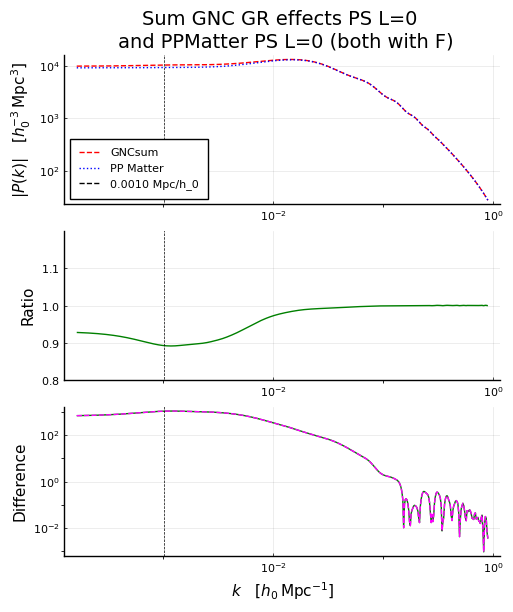

In [26]:
xs_1 = ks_GNC_L0_withF
ys_1 = pks_sum_GNC_L0_withF

xs_2 = ks_ppm_L0_withF
ys_2 = pks_ppm_L0_withF
spline = Spline1D(xs_2, ys_2)

xs_3 = ks
ys_3 = diff_GNCsum_ppm

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "Sum GNC GR effects PS L=0 \n and PPMatter PS L=0 (both with F)",
    label=["GNCsum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_L0_GNCsum-PPMatter_withF.pdf")
#display(P)

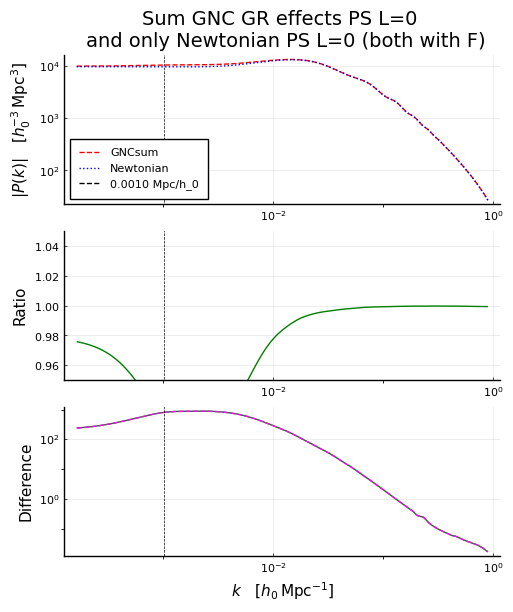

In [27]:
xs_1 = ks_GNC_L0_withF
ys_1 = pks_sum_GNC_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)

xs_3 = ks
ys_3 = diff_GNCsum_Newt

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "Sum GNC GR effects PS L=0 \n and only Newtonian PS L=0 (both with F)",
    label=["GNCsum" "Newtonian"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.95,1.05), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log, 
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_L0_GNCsum-Newton_withF.pdf")
#display(P)

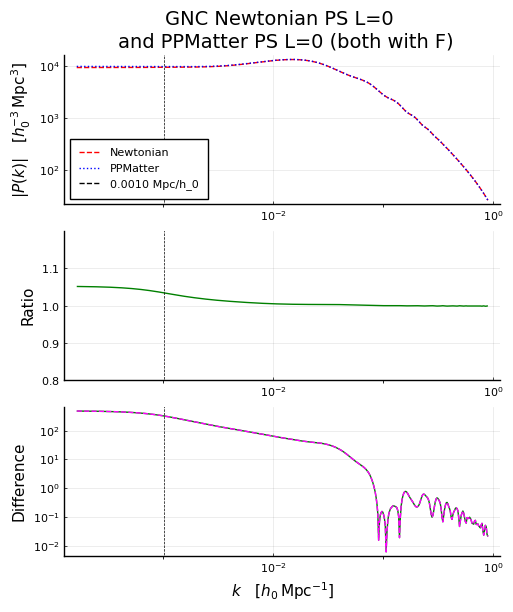

In [28]:
xs_1 = ks_ppm_L0_withF
ys_1 = pks_ppm_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)


xs_3 = ks_ALLGRsum_L0_withF
ys_3 = diff_Newt_ppm

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "GNC Newtonian PS L=0 \n and PPMatter PS L=0 (both with F)",
    label=["Newtonian" "PPMatter"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_L0_Newton-PPMatter_withF.pdf")
#display(P)

## Check plots sum of the GNC GR effects

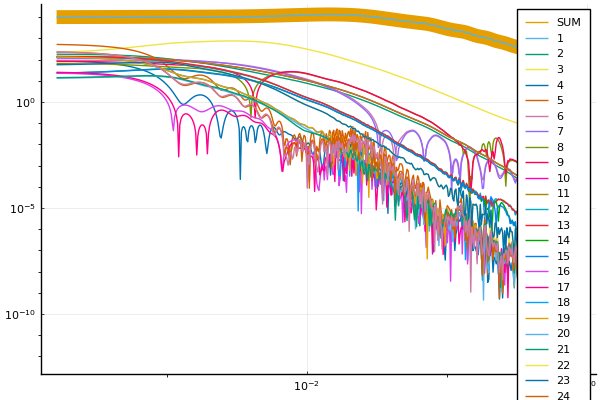

In [29]:
p=plot(ks, abs.(pks_sum_GNC_L0_withF), axis=:log, label="SUM", lw=10)
for (i,effect) in enumerate(GaPSE.GR_EFFECTS_GNC)
    plot!(p, ks, abs.(pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC[effect]]), label="$i")
end
p

auto_newton
auto_doppler
auto_lensing
auto_localgp
auto_integratedgp
newton_doppler
doppler_newton
newton_lensing
lensing_newton
newton_localgp
localgp_newton
newton_integratedgp
integratedgp_newton
lensing_doppler
doppler_lensing
doppler_localgp
localgp_doppler
doppler_integratedgp
integratedgp_doppler
lensing_localgp
localgp_lensing
lensing_integratedgp
integratedgp_lensing
localgp_integratedgp
integratedgp_localgp


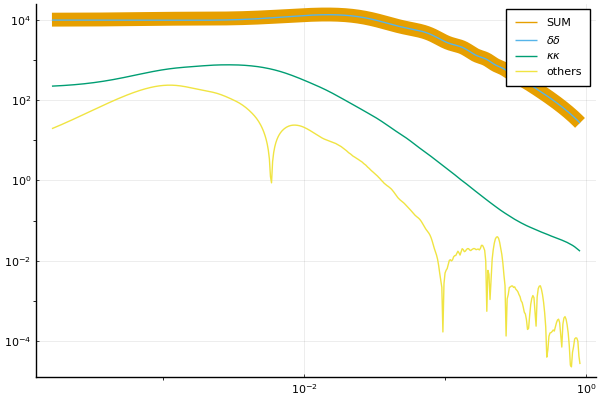

In [30]:
p = plot(ks, abs.(pks_sum_GNC_L0_withF), axis=:log, label="SUM", lw=10)

plot!(p, ks, abs.(pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]]), label=L"\delta\delta")
plot!(p, ks, abs.(pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]]), label=L"\kappa\kappa")

others = -1.0 .* (pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]] .+ pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]])
for (i,effect) in enumerate(GaPSE.GR_EFFECTS_GNC)
    println(effect)
    others += pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC[effect]]
end
plot!(p, ks, abs.(others), label="others")

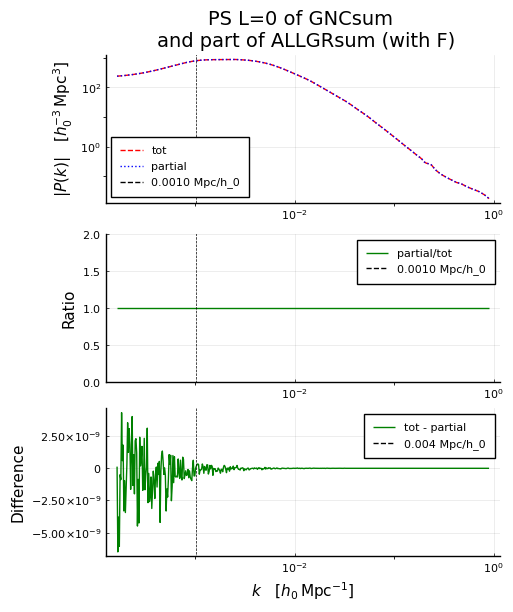

In [31]:
xs_1 = ks
ys_1 = pks_sum_GNC_L0_withF .- pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]] 

xs_2 = ks
ys_2 = pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+ others

spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS L=0 of GNCsum \n and part of ALLGRsum (with F)",
    label=["tot" "partial"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, ys_1 ./ spline.(xs_1), 
    ylabel="Ratio", lc=:green, ylim = (0, 2),
    xaxis=:log, label="partial/tot",
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, ys_1 .- spline.(xs_1), 
    label="tot - partial", lc=:green, 
    xaxis=:log, ylabel="Difference",
    legend=true, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_S-GNCsum-Newt-PPmatter_L0_withF.pdf")
#display(P)

## Results

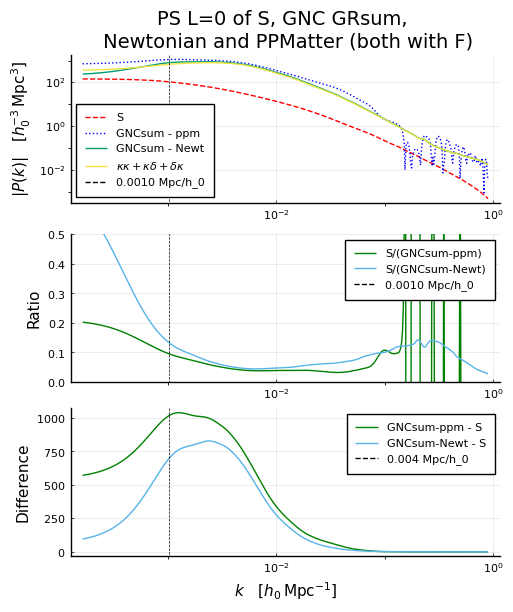

In [32]:
xs_1 = ks_S_L0_withF
ys_1 = pks_S_L0_withF


xs_4 = ks
ys_4 = pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+
        pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]] .+
        pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]]

xs_2 = ks
ys_2 = diff_GNCsum_ppm

xs_3 = ks
ys_3 = diff_GNCsum_Newt

spline_2 = Spline1D(xs_2, ys_2)
spline_3 = Spline1D(xs_3, ys_3)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS L=0 of S, GNC GRsum, \n Newtonian and PPMatter (both with F)",
    label=["S" "GNCsum - ppm"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
plot!(p1, xs_3, abs.(ys_3), label="GNCsum - Newt")
plot!(p1, xs_4, abs.(ys_4), label=L"\kappa\kappa + \kappa\delta + \delta\kappa")
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, ys_1 ./ spline_2.(xs_1), 
    ylabel="Ratio", lc=:green, ylim = (0,0.5),
    xaxis=:log, label="S/(GNCsum-ppm)",
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, ys_1 ./ spline_3.(xs_1), label="S/(GNCsum-Newt)")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, spline_2.(xs_1) .- ys_1, 
    label="GNCsum-ppm - S", lc=:green, 
    xaxis=:log, ylabel="Difference",
    legend=true, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_1, spline_3.(xs_1) .- ys_1, label="GNCsum-Newt - S")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, DIR*"PS_S-GNCsum-Newt-PPmatter_L0_withF.pdf")
#display(P)

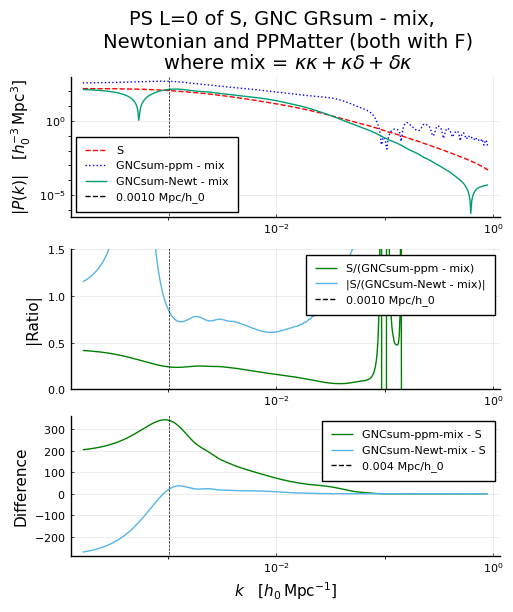

In [33]:
xs_1 = ks_S_L0_withF
ys_1 = pks_S_L0_withF


xs_4 = ks
ys_4 = pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+ 
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]] .+ 
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]]

xs_2 = ks
ys_2 = diff_GNCsum_ppm .- ys_4

xs_3 = ks
ys_3 = diff_GNCsum_Newt .- ys_4

spline_2 = Spline1D(xs_2, ys_2)
spline_3 = Spline1D(xs_3, ys_3)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS L=0 of S, GNC GRsum - mix, \n Newtonian and PPMatter (both with F)\n where mix = "*L"\kappa\kappa + \kappa\delta + \delta\kappa",
    label=["S" "GNCsum-ppm - mix"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
plot!(p1, xs_3, abs.(ys_3), label="GNCsum-Newt - mix")
#plot!(p1, xs_4, abs.(ys_4), label=L"\kappa\kappa + \kappa\delta + \delta\kappa")
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, ys_1 ./ spline_2.(xs_1), 
    ylabel="|Ratio|", lc=:green, ylim = (0,1.5),
    xaxis=:log, label="S/(GNCsum-ppm - mix)",
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, abs.(ys_1 ./ spline_3.(xs_1)), label="|S/(GNCsum-Newt - mix)|")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, spline_2.(xs_1) .- ys_1, 
    label="GNCsum-ppm-mix - S", lc=:green, 
    xaxis=:log, ylabel="Difference",
    legend=true, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_1, spline_3.(xs_1) .- ys_1, label="GNCsum-Newt-mix - S")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, DIR*"PS_S-GNCsum-Newt-PPmatter_L0_withF_2.pdf")
#display(P)